In [1]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


e:\Installation\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
e:\Installation\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

df = read_excel('../../Data/Processed data/ssmc.xlsx')

In [3]:
df.head()

,Date,Affected
0,2021/12/13,-
1,2021/12/14,4
2,2021/12/15,-
3,2021/12/16,-
4,2021/12/17,-


In [4]:
df.shape

(699, 2)

In [5]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
#sort by date
df = df.sort_values(by='Date')
# for rows where df['Affected'] is null or non-numeric, replace with 0
df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
df.reset_index(drop=True, inplace=True)

In [6]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
window_size = 14
input_size = window_size - 1
hidden_size = 64
num_layers = 1

print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  14  input_size:  13  num_layers:  1


In [7]:

def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples



samples = create_time_series_samples(df, window_size)

In [8]:
samples[0].head(11)

,Date,Affected
0,1.567296e+18,56.0
1,1.567382e+18,54.0
2,1.567469e+18,64.0
3,1.567728e+18,0.0
4,1.567814e+18,35.0
5,1.567901e+18,53.0
6,1.568074e+18,47.0
7,1.568160e+18,30.0
8,1.568246e+18,33.0
9,1.568333e+18,23.0


In [9]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,56.0,54.0,64.0,0.0,35.0,53.0,47.0,30.0,33.0,23.0,22.0,20.0,32.0,44.0
1,54.0,64.0,0.0,35.0,53.0,47.0,30.0,33.0,23.0,22.0,20.0,32.0,44.0,23.0
2,64.0,0.0,35.0,53.0,47.0,30.0,33.0,23.0,22.0,20.0,32.0,44.0,23.0,23.0
3,0.0,35.0,53.0,47.0,30.0,33.0,23.0,22.0,20.0,32.0,44.0,23.0,23.0,33.0
4,35.0,53.0,47.0,30.0,33.0,23.0,22.0,20.0,32.0,44.0,23.0,23.0,33.0,17.0


In [10]:
affected_df.shape

(686, 14)

In [11]:

def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, True)

In [12]:
test_df.shape

(138, 14)

In [13]:
train_df.shape

(548, 14)

In [14]:


def split_X_y(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [15]:
print(X_train.shape)
print(y_train.shape)

(548, 13)
(548,)


In [16]:
print(X_test.shape)
print(y_test.shape)

(138, 13)
(138,)


In [17]:
print("X-train shape: ", X_train.shape)
print("y-train shape: ", y_train.shape)
print("X-test shape: ", X_test.shape)
print("y-test shape: ", y_test.shape)

X-train shape:  (548, 13)
y-train shape:  (548,)
X-test shape:  (138, 13)
y-test shape:  (138,)


In [18]:
def get_train_test_loader(X_train, y_train, X_test, y_test, batch_size):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)

    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, X_test_tensor, y_test_tensor


In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  
        return out

In [20]:
def initialize_the_model(input_size, hidden_size, num_layers):
    model = LSTMModel(input_size, hidden_size, num_layers)
    return model

def get_loss_and_optimizer(model, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return criterion, optimizer

In [21]:
def train(model, criterion, optimizer, train_loader, num_epochs):
    train_losses = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        train_losses[epoch] = loss.item()

    return train_losses

In [22]:
def pred(model, criterion, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor.unsqueeze(1))
        test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
        print(f'Test Loss: {test_loss.item():.4f}')

    predictions = test_outputs.numpy()
    return predictions

In [23]:
def plot_predictions(y_test, predictions):
    y_test = y_test.reset_index(drop=True)
    plt.figure(figsize=(12, 5))
    plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}')
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()

In [24]:
def plot_loss(train_losses):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training loss')
    plt.legend()
    plt.show()

In [25]:
train_loader, test_loader, X_test_tensor, y_test_tensor = get_train_test_loader(X_train, y_train, X_test, y_test, batch_size)
model = initialize_the_model(input_size, hidden_size, num_layers)
criterion, optimizer = get_loss_and_optimizer(model, learning_rate)
train_losses = train(model, criterion, optimizer, train_loader, num_epochs)
predictions = pred(model, criterion, X_test_tensor, y_test_tensor)

Epoch [1/500], Loss: 229.1951
Epoch [2/500], Loss: 90.0743
Epoch [3/500], Loss: 791.1296
Epoch [4/500], Loss: 73.8031
Epoch [5/500], Loss: 77.8596
Epoch [6/500], Loss: 521.2575
Epoch [7/500], Loss: 565.4801
Epoch [8/500], Loss: 3844.1196
Epoch [9/500], Loss: 31.0967
Epoch [10/500], Loss: 117.1778
Epoch [11/500], Loss: 33.3070
Epoch [12/500], Loss: 230.3673


Epoch [13/500], Loss: 2622.7551
Epoch [14/500], Loss: 3514.3306
Epoch [15/500], Loss: 28.8330
Epoch [16/500], Loss: 653.7255
Epoch [17/500], Loss: 450.1968
Epoch [18/500], Loss: 300.2954
Epoch [19/500], Loss: 426.9982
Epoch [20/500], Loss: 20.4846
Epoch [21/500], Loss: 350.0082
Epoch [22/500], Loss: 902.7125
Epoch [23/500], Loss: 168.7063
Epoch [24/500], Loss: 868.7372
Epoch [25/500], Loss: 136.0544
Epoch [26/500], Loss: 14.1584
Epoch [27/500], Loss: 411.7626
Epoch [28/500], Loss: 157.8257
Epoch [29/500], Loss: 618.0670
Epoch [30/500], Loss: 1344.0544
Epoch [31/500], Loss: 1324.8160
Epoch [32/500], Loss: 19.0976
Epoch [33/500], Loss: 26.1302
Epoch [34/500], Loss: 15.9173
Epoch [35/500], Loss: 314.6366
Epoch [36/500], Loss: 1716.3932
Epoch [37/500], Loss: 260.0618
Epoch [38/500], Loss: 822.2764
Epoch [39/500], Loss: 181.9928
Epoch [40/500], Loss: 820.0999
Epoch [41/500], Loss: 212.9883
Epoch [42/500], Loss: 54.0827
Epoch [43/500], Loss: 54.1377
Epoch [44/500], Loss: 97.5543
Epoch [45/50

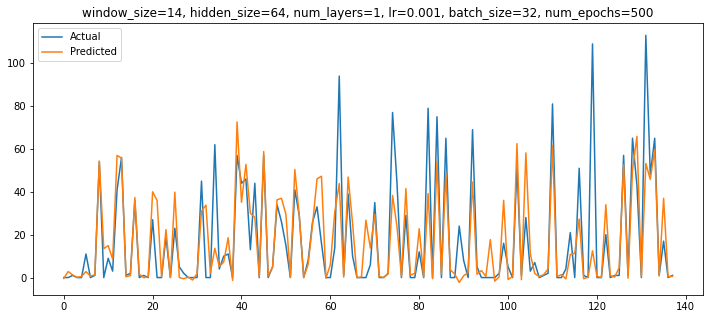

In [26]:
plot_predictions(y_test, predictions)

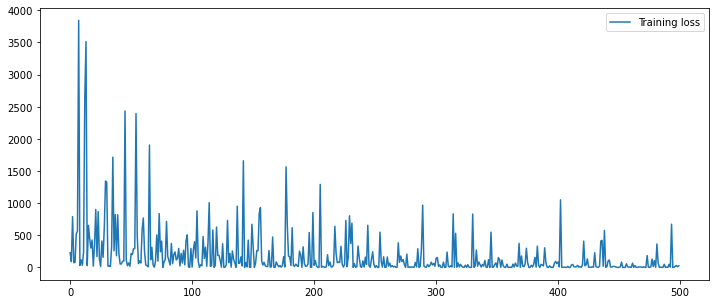

In [27]:
plot_loss(train_losses)

In [28]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error


print("MAE: ", round(mean_absolute_error(y_test, predictions), 2))
print("MSE: ", round(mean_squared_error(y_test, predictions), 2))
print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, predictions)), 2))



MAE:  8.76
MSE:  259.29
RMSE:  16.1


In [29]:
y_test.shape

(138,)

In [30]:
!pip install python-docx

In [31]:
def plot_predictions_2(y_test, predictions):
    y_test = y_test.reset_index(drop=True)
    plt.figure(figsize=(12, 5))
    #add hyperparameters to title
    plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}')
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()
    plt.savefig('test_dir/lstm_dmc.png')
    #save plot in a docx file
    from docx import Document
    from docx.shared import Inches
    document = Document()
    document.add_heading('LSTM')
    document.add_picture('test_dir/lstm_dmc.png', width=Inches(6.25))
    document.save('test_dir/lstm_dmc.docx')

In [32]:
# plot_predictions_2(y_test, predictions)

In [33]:
train_losses

array([2.29195068e+02, 9.00742569e+01, 7.91129639e+02, 7.38031387e+01,
       7.78596268e+01, 5.21257507e+02, 5.65480103e+02, 3.84411963e+03,
       3.10967121e+01, 1.17177795e+02, 3.33069801e+01, 2.30367264e+02,
       2.62275513e+03, 3.51433057e+03, 2.88330421e+01, 6.53725525e+02,
       4.50196808e+02, 3.00295380e+02, 4.26998169e+02, 2.04845695e+01,
       3.50008179e+02, 9.02712463e+02, 1.68706299e+02, 8.68737183e+02,
       1.36054413e+02, 1.41584330e+01, 4.11762604e+02, 1.57825745e+02,
       6.18067017e+02, 1.34405444e+03, 1.32481604e+03, 1.90976353e+01,
       2.61302414e+01, 1.59173374e+01, 3.14636597e+02, 1.71639319e+03,
       2.60061798e+02, 8.22276367e+02, 1.81992767e+02, 8.20099854e+02,
       2.12988251e+02, 5.40827103e+01, 5.41377144e+01, 9.75543365e+01,
       1.00110985e+02, 2.43413208e+03, 1.14062096e+02, 2.71887341e+01,
       7.02447968e+01, 1.95608482e+01, 2.16191711e+02, 2.02603546e+02,
       2.92899506e+02, 2.96920929e+02, 2.39429688e+03, 4.89320343e+02,
      